<Center>
<b>Assignment 1: </b><br> 
Cornelis de Jager n8891974 <br>
Daniel Brandenburg n8867887 <br>
Joel Schwaber n10241337 
</center>

In [4]:

# Run this if pydot needs to be installed
!pip install pydot
!pip install eli5


In [5]:
# Imports
import pandas as pd
import numpy as np
import scipy.stats as stats

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

import eli5

# Import ML libraries
from sklearn.preprocessing import Imputer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import VotingClassifier

# Set a random state value
rs = 10

#import libraries to visualize decision trees
import pydot
from io import StringIO


# Ignore Warnings and ignore them
import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'imblearn'

In [ ]:
def categoricalPlot(cat, cat2 = 'IsBadBuy'): # Cat is the carigorical as a string i.e 'Size'
    pd.crosstab(data[cat],data[cat2]).plot(kind="bar")
    
def CreateAveragedColumn (A, B):
    C = [np.nan] * len( A )
    for i in range(len(A)):
        C[i] = (A[i] + B[i])/2
    
    return C

def IdentifyOutliers (column):
    data_described = column.describe()
    Q1 = data_described["25%"]
    Q3 = data_described["75%"]
    IQR = Q3-Q1
    lowerLimit = Q1 - 1.5 * IQR
    upperLimit = Q3 + 1.5 * IQR
    output = [np.nan] * len( column )
    for i in range(len(column)):
        value = column[i]
        if value < lowerLimit or value > upperLimit:
            output[i] = True
        else:
            output[i] = False
    return output

def analyse_feature_importance(dm_model, feature_names, n_to_display=5):
    # grab feature importances from the model
    importances = dm_model.feature_importances_
    
    # sort them out in descending order
    indices = np.argsort(importances)
    indices = np.flip(indices, axis=0)

    # limit to 20 features, you can leave this out to print out everything
    indices = indices[:n_to_display]

    for i in indices:
        print(feature_names[i], ':', importances[i])
        
# Define a function to find the root node
def getTreeInfo(model, feature_names):
    n_nodes = model.tree_.node_count
    children_left = model.tree_.children_left
    children_right = model.tree_.children_right
    feature = model.tree_.feature
    threshold = model.tree_.threshold
    features  = [feature_names[i] for i in model.tree_.feature]    

    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    leaf_count = 0
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1
        
        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            leaf_count += 1
            is_leaves[node_id] = True

    print("The binary tree structure has ", n_nodes, " nodes and has ", leaf_count, " leaves")

    print("Root feature is ", features[0])
    print("Competing featues are ", features[2], 'and ', features[3])
    
# Write a function that imputes median
def ImputeMean(series):
    return series.fillna(series.mean())

def Normalize (column):
    column =  (column - column.min())/(column.max() - column.min())
    return column

def LogTransform (column):
    column = math.log(column)

In [6]:
def PreProcessing (data):
    print("Pre-Processing Step")
    
    # Check if there are any missing target variables
    if data['IsBadBuy'].isna().any():
        print("Missing Target Variables")
    else:
        print("No missing Target Variables")
    
    
    # Handle Bad Columns drop Columns
    data.drop(['PRIMEUNIT', 'AUCGUART', 'WheelTypeID', 'ForSale', 'PurchaseDate', 'IsOnlineSale'], 
              axis=1, 
              inplace=True)
    

    # Handle Missing Values
    i = 0            # Python's indexing starts at zero
    for item in data['TopThreeAmericanName']:   # Python's for loops are a "for each" loop 
        if data['TopThreeAmericanName'][i] == np.nan and  data['Make'][i] == 'Hyundai':
            data['TopThreeAmericanName'][i] = 'HYUNDAI'
        i += 1
        
    i = 0            # Python's indexing starts at zero
    for item in data['TopThreeAmericanName']:   # Python's for loops are a "for each" loop 
        if data['TopThreeAmericanName'][i] == np.nan and  data['Make'][i] == 'Jeep':
            data['TopThreeAmericanName'][i] = 'JEEP'
        i += 1
        
        
    """ DOES THIS HAVE TO BE THERE """
    # print(data.groupby(['TopThreeAmericanName'])['Make'].value_counts())
    """ DOES THIS HAVE TO BE THERE """
    
    

    # Standardise the capitilization across all object rows
    obj_cols = data.select_dtypes(include='object').columns # Create a list of col names
    for i in obj_cols:              # Interate over the obj_cols list
        data[i] = data[i].str.upper()   # Convert all strings to uppercase  
    # Standardize USA to AMERICA
    data['Nationality'].replace({'USA' : 'AMERICAN'}, inplace = True)
    
    # Turn Transmission into a binary variable with Auto = 1 and Manual = 0
    data.rename({'Transmission' : 'Auto'}, axis = 1, inplace = True)
    # Replace binary columns with 1s and 0s
    data['Auto'].replace({'MANUAL' : 0, 'AUTO' : 1}, inplace=True)
    
    # Remove NOT AVAIL in color and place it in the NaN section
    data['Color'].replace({'NOT AVAIL': np.nan}, inplace = True)
    
    
    #This is the significance test for 
    # Check to see if VNST is a statisically significant variable
    # Create a distribution of IsBuyBad for VNST
    VNST_badBuy = pd.crosstab(data['IsBadBuy'], data['VNST']).loc[0]
    VNST_goodBuy = pd.crosstab(data['IsBadBuy'], data['VNST']).loc[1]
    pd.crosstab(data['VNST'],data['IsBadBuy']).plot(kind="bar")
    
    # Use a Chi2 test to test if there is any corrilation between them, if there is
    # (p < 0.05) discarde the variable
    fScore, pValue = stats.f_oneway(VNST_badBuy, VNST_goodBuy)
    print("The pValaue is " + str(pValue) + " which is significant enough to reject null hypothesis")
    print("Drop VNST due to statistical insignificance")
    data.drop('VNST', axis=1, inplace = True)
    
    # Seperate the Size feature into Size and Body
    tempSize = data['Size'].str.split(' ', expand = True) # Create temp var with split column
    data['Size'] = tempSize[0] # Save the temp var back into data
    data['Body'] = tempSize[1] # Save the temp var back into data
    data['Body'].fillna('CITY', inplace = True) # Assume any other cars are 'City'
    
    
    data.loc[data.Size == 'VAN', 'Body'] = 'Van' # Convert Van into a body type
    data.loc[data.Size == 'VAN', 'Size'] =  np.nan # Take van away from size, shouldn't matter once OH is done
    
    # Converting the TimeStamp into Quater
    Quarter = [] # Create empty string
    for i, _ in enumerate(data.PurchaseTimestamp): # Loop over the entire dataset
        # Convert the epoch datetime into the quater and append to list
        Quarter.append(pd.Timestamp(data.PurchaseTimestamp.loc[i], unit = 's').quarter)        
    data['Quarter'] = Quarter # Create the column with list
    data.drop('PurchaseTimestamp', axis=1, inplace = True) # Drop old TimeStamp
            

    
    data['MMRAcquisitionAuctionAveragePrice'] = data['MMRAcquisitionAuctionAveragePrice'].replace(0, np.nan)
    data['MMRAcquisitionAuctionCleanPrice'] = data['MMRAcquisitionAuctionCleanPrice'].replace(0, np.nan)
    data['MMRAcquisitionRetailAveragePrice'] = data['MMRAcquisitionRetailAveragePrice'].replace(0, np.nan)
    data['MMRAcquisitonRetailCleanPrice'] = data['MMRAcquisitonRetailCleanPrice'].replace(0, np.nan)
    data['MMRCurrentAuctionAveragePrice'] = data['MMRCurrentAuctionAveragePrice'].replace(0, np.nan)
    data['MMRCurrentAuctionCleanPrice'] = data['MMRCurrentAuctionCleanPrice'].replace(0, np.nan)
    data['MMRCurrentRetailAveragePrice'] = data['MMRCurrentRetailAveragePrice'].replace(0, np.nan)
    data['MMRCurrentRetailCleanPrice'] = data['MMRCurrentRetailCleanPrice'].replace(0, np.nan)    
    
    # Impute and normalize
    data["VehOdo"] = Normalize(ImputeMean(data["VehOdo"]))
    data["VehBCost"] = Normalize(ImputeMean(data["VehBCost"]))
    data["WarrantyCost"] = Normalize(ImputeMean(data["WarrantyCost"]))
    data["MMRAcquisitionAuctionAveragePrice"] = Normalize(ImputeMean(data["MMRAcquisitionAuctionAveragePrice"]))
    data["MMRAcquisitionAuctionCleanPrice"] =  Normalize(ImputeMean(data["MMRAcquisitionAuctionCleanPrice"]))
    data["MMRAcquisitionRetailAveragePrice"] =  Normalize(ImputeMean(data["MMRAcquisitionRetailAveragePrice"]))
    data["MMRAcquisitonRetailCleanPrice"] =  Normalize(ImputeMean(data["MMRAcquisitonRetailCleanPrice"]))
    data["MMRCurrentAuctionAveragePrice"] =  Normalize(ImputeMean(data["MMRCurrentAuctionAveragePrice"]))
    data["MMRCurrentAuctionCleanPrice"] =  Normalize(ImputeMean(data["MMRCurrentAuctionCleanPrice"]))
    data["MMRCurrentRetailAveragePrice"] =  Normalize(ImputeMean(data["MMRCurrentRetailAveragePrice"]))
    data["MMRCurrentRetailCleanPrice"] =  Normalize(ImputeMean(data["MMRCurrentRetailCleanPrice"]))
       
    print("----------\nShow significantly similar columns")
    print("MMRAcquisitionAuctionAveragePrice and MMRAcquisitionAuctionCleanPrice", np.corrcoef(data["MMRAcquisitionAuctionAveragePrice"], data["MMRAcquisitionAuctionCleanPrice"]))
    print("MMRAcquisitionRetailAveragePrice and MMRAcquisitonRetailCleanPrice",np.corrcoef(data["MMRAcquisitionRetailAveragePrice"], data["MMRAcquisitonRetailCleanPrice"]))
    print("MMRCurrentAuctionAveragePrice and MMRCurrentAuctionCleanPrice",np.corrcoef(data["MMRCurrentAuctionAveragePrice"], data["MMRCurrentAuctionCleanPrice"]))
    print("MMRCurrentRetailAveragePrice and MMRCurrentRetailCleanPrice",np.corrcoef(data["MMRCurrentRetailAveragePrice"], data["MMRCurrentRetailCleanPrice"])) 
    
    #print(data["MMRAcquisitionAuctionAveragePrice"][data["MMRAcquisitionAuctionAveragePrice"] == 0])
    
    """ Create the new columns """
    data["AcquisitionAuctionprice"] = CreateAveragedColumn(data["MMRAcquisitionAuctionAveragePrice"], data["MMRAcquisitionAuctionCleanPrice"])
    data["AcquisitionRetailPrice"] = CreateAveragedColumn(data["MMRAcquisitionRetailAveragePrice"], data["MMRAcquisitonRetailCleanPrice"])
    data["MMRCurrentAuctionPrice"] = CreateAveragedColumn(data["MMRCurrentAuctionAveragePrice"], data["MMRCurrentAuctionCleanPrice"])
    data["MMRCurrentRetailPrice"] = CreateAveragedColumn(data["MMRCurrentRetailAveragePrice"], data["MMRCurrentRetailCleanPrice"])
       
    
    data.drop('MMRAcquisitionAuctionAveragePrice', inplace = True, axis = 1)
    data.drop('MMRAcquisitionAuctionCleanPrice', inplace = True, axis = 1)
    data.drop('MMRAcquisitonRetailCleanPrice', inplace = True, axis = 1)
    data.drop('MMRCurrentAuctionAveragePrice', inplace = True, axis = 1)
    data.drop('MMRCurrentAuctionCleanPrice', inplace = True, axis = 1)
    data.drop('MMRCurrentRetailAveragePrice', inplace = True, axis = 1)
    data.drop('MMRCurrentRetailCleanPrice', inplace = True, axis = 1)
    data.drop('MMRAcquisitionRetailAveragePrice', inplace = True, axis = 1)
    
    """ This will take care of any Null values we don't specifically take care of
    by replaceing the missing data with data from the same distibution"""
    conv = []
    for i in data.columns: # Loop over dataset
        if data[i].isna().any() == True: # Check to see if there is a NaN is the feature
            dist = data[i].value_counts(normalize=True) # Find the distrabution of the column
            missing = data[i].isna() # Find where the NaN are
            # Replace the NaNs with values from the same distrabution of the column
            data.loc[missing, i] = np.random.choice(dist.index, size=len(data[missing]),p=dist.values)       
            conv.append(i)
    print("Converted all of " , conv, "s missing values into the same distrubution")
    
    # Do the box plot
    fig = plt.figure()
    data.boxplot(column=['AcquisitionAuctionprice', 'AcquisitionRetailPrice', 'MMRCurrentAuctionPrice', 'MMRCurrentRetailPrice'], grid = False, rot = 30)
    plt.savefig('preOutlierBox', bbox_inches = "tight")
    plt.show
    
    
    # Now do histograms
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    plt.subplots_adjust(hspace=0.4, wspace = 0.3)
    ax1 =  data["AcquisitionAuctionprice"].hist()
    ax1.set_title("AcquisitionAuctionprice")
    ax1.grid(False)
    ax2 = fig.add_subplot(2,2,2)
    ax2 =  data["AcquisitionRetailPrice"].hist()
    ax2.set_title("AcquisitionRetailPrice")
    ax2.grid(False)
    ax3 = fig.add_subplot(2,2,3)
    ax3 =  data["MMRCurrentAuctionPrice"].hist()
    ax3.set_title("MMRCurrentAuctionPrice")
    ax3.grid(False)
    ax4 = fig.add_subplot(2,2,4)
    ax4 =  data["MMRCurrentRetailPrice"].hist()
    ax4.set_title("MMRCurrentRetailPrice")
    ax4.grid(False)
    plt.savefig('preOutlierHist', bbox_inches = "tight")
    plt.show()
    

    ## Identify and Remove outiers
    outliers = (IdentifyOutliers(data["AcquisitionAuctionprice"]) and
                IdentifyOutliers(data["AcquisitionRetailPrice"]) and
                IdentifyOutliers(data["MMRCurrentAuctionPrice"]) and
                IdentifyOutliers(data["MMRCurrentRetailPrice"]))
    
    # Select lines that aren't outliers
    num_lines =  len(data["MMRCurrentRetailPrice"])
    data = data[[not i for i in outliers]]
    print ("Lines Removed: ", num_lines - len(data["MMRCurrentRetailPrice"]))
    
    # Do the box plot
    fig = plt.figure()
    data.boxplot(column=['AcquisitionAuctionprice', 'AcquisitionRetailPrice', 'MMRCurrentAuctionPrice', 'MMRCurrentRetailPrice'], grid = False, rot = 45)
    plt.savefig('postOutlierBox', bbox_inches = "tight")
    plt.show
    
    # Now do histograms
    fig = plt.figure()
    plt.subplots_adjust(hspace=0.4, wspace = 0.3)
    ax1 = fig.add_subplot(2,2,1)
    ax1 =  data["AcquisitionAuctionprice"].hist()
    ax1.set_title("AcquisitionAuctionprice")
    ax1.grid(False)
    ax2 = fig.add_subplot(2,2,2)
    ax2 =  data["AcquisitionRetailPrice"].hist()
    ax2.set_title("AcquisitionRetailPrice")
    ax2.grid(False)
    ax3 = fig.add_subplot(2,2,3)
    ax3 =  data["MMRCurrentAuctionPrice"].hist()
    ax3.set_title("MMRCurrentAuctionPrice")
    ax3.grid(False)
    ax4 = fig.add_subplot(2,2,4)
    ax4 =  data["MMRCurrentRetailPrice"].hist()
    ax4.set_title("MMRCurrentRetailPrice")
    ax4.grid(False)
    plt.savefig('postOutlierHist', bbox_inches = "tight")
    plt.show()
    
    fig = plt.figure()
    ax1 =  data["Make"].value_counts().plot(kind = 'bar')
    ax1.set_title("Make")
    ax1.grid(False)
    plt.savefig('makeHist', bbox_inches = "tight")
    plt.show()
    
    fig = plt.figure()
    ax1 =  data["Color"].value_counts().plot(kind = 'bar')
    ax1.set_title("Color")
    ax1.grid(False)
    plt.savefig('colourHist', bbox_inches = "tight")
    plt.show()
    
    fig = plt.figure()
    plt.subplots_adjust(hspace=0.8, wspace = 0.4)
    ax1 = fig.add_subplot(2,2,1)
    ax1 =  data["VehYear"].value_counts().plot(kind = 'bar', rot = 90)
    ax1.set_title("VehYear")
    ax1.grid(False)
    ax2 = fig.add_subplot(2,2,2)
    ax2 =  data["Auction"].value_counts().plot(kind = 'bar', rot = 90)
    ax2.set_title("Auction")
    ax2.grid(False)
    ax3 = fig.add_subplot(2,2,3)
    ax3 =  data["Size"].value_counts().plot(kind = 'bar', rot = 90)
    ax3.set_title("Size")
    ax3.grid(False)
    ax4 = fig.add_subplot(2,2,4)
    ax4 =  data["Body"].value_counts().plot(kind = 'bar', rot = 90)
    ax4.set_title("Body")
    ax4.grid(False)
    plt.savefig('othersHist', bbox_inches = "tight")
    plt.show()
    
    """ This should be the last thing done """
    # Convert all categorical variables into one hot representations
    
    print("The number of features before one hot encoding is " + str(data.shape[1]))
    data_OH = pd.get_dummies(data, columns = ['Auction', 'Make', 'Color', 'VehYear', 
                                              'Nationality', 'Size', 'Body', 'TopThreeAmericanName', 
                                              'WheelType', 'Quarter'])
    print("The number of features after one hot encoding is " + str(data_OH.shape[1]))
    data_OH ["IsBadBuy"] = data['IsBadBuy']
    
    data.describe()
    data.info()
    
    return data, data_OH

Pre-Processing Step
No missing Target Variables
The pValaue is 0.0025217411235946108 which is significant enough to reject null hypothesis
Drop VNST due to statistical insignificance


NameError: name 'Normalize' is not defined

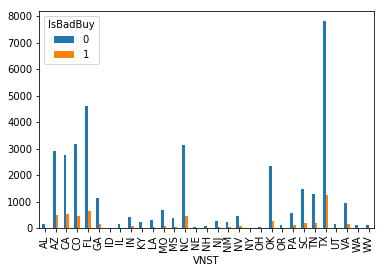

In [7]:
data_raw = pd.read_csv("Kick.csv", # Read the csv into a DF
                   index_col = 'PurchaseID', 
                   na_values = ('?',  '#VALUE!'))

data, data_OH = PreProcessing(data_raw) # PreProcess the data

counts = data["IsBadBuy"].value_counts()
total = data["IsBadBuy"].count()
    
# calculate the percentage
# kick is where IsBadBuy == 1
kickPersentage = counts[1] / total * 100
print ("Questin 1.1 :")
print( kickPersentage, "%")

# target/input split
y = data_OH['IsBadBuy']
X = data_OH.drop(['IsBadBuy'], axis=1)

X_mat = X.values # Canvert X into a matrix
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.2, stratify=y, random_state=rs)

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

print(sorted(Counter(y_resampled).items()))

# Decision Tree

In [6]:
 """ Dicision Treee """
modelDT = DecisionTreeClassifier(random_state=rs) # Define the model
modelDT.fit(X_train, y_train) # Fit with data

print("Train accuracy:", modelDT.score(X_train, y_train))
print("Test accuracy:", modelDT.score(X_test, y_test))

y_predDT = modelDT.predict(X_test) # Predict the data
print(classification_report(y_test, y_predDT)) # Print the scores

# grab feature importances from the model and feature name from the original X
feature_names = X.columns

analyse_feature_importance(modelDT, feature_names, n_to_display=5)

getTreeInfo(modelDT, feature_names) # Call the root function

Train accuracy: 1.0
Test accuracy: 0.778693491697976
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      7185
           1       0.18      0.19      0.18      1066

   micro avg       0.78      0.78      0.78      8251
   macro avg       0.53      0.53      0.53      8251
weighted avg       0.79      0.78      0.78      8251

VehOdo : 0.11616065059041912
VehBCost : 0.11220236775770132
MMRCurrentAuctionPrice : 0.09312490191337479
MMRCurrentRetailRatio : 0.09086528262244385
AcquisitionAuctionprice : 0.08116783012299643
The binary tree structure has  8581  nodes and has  4291  leaves
Root feature is  MMRCurrentAuctionPrice
Competing featues are  VehYear_2001.0 and  VehYear_2002.0


In [7]:
"""# Create a graph of the tree
def DTreeGraph(model, colNames):
    dotfile = StringIO()
    export_graphviz(model, out_file=dotfile, feature_names=colNames)
    graph = pydot.graph_from_dot_data(dotfile.getvalue())
    graph[0].write_png('grpah.png') # saved in the following file


#This is take a while
DTreeGraph(modelDT, feature_names)
"""

"# Create a graph of the tree\ndef DTreeGraph(model, colNames):\n    dotfile = StringIO()\n    export_graphviz(model, out_file=dotfile, feature_names=colNames)\n    graph = pydot.graph_from_dot_data(dotfile.getvalue())\n    graph[0].write_png('grpah.png') # saved in the following file\n\n\n#This is take a while\nDTreeGraph(modelDT, feature_names)\n"

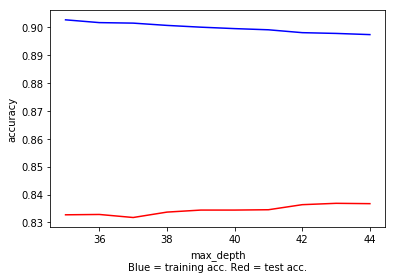

VehBCost : 0.11488253797371291
VehOdo : 0.1129273278301014
MMRCurrentAuctionPrice : 0.1080996149320328
MMRCurrentRetailRatio : 0.09970472435497198
AcquisitionAuctionprice : 0.07596330662078263
The binary tree structure has  3181  nodes and has  1591  leaves
Root feature is  MMRCurrentAuctionPrice
Competing featues are  VehYear_2001.0 and  VehYear_2002.0

---------
The best test accuracy was  0.8367470609623076  with a training score of 0.8974242424242425


In [8]:
#retrain with a larger minimum number of samples required to split an internal node
test_scoreDT = []
train_scoreDT = []

range_ = range(35, 45)

# check the model performance for max depth from 2-20
for min_samples_split in range_:
    modelDT = DecisionTreeClassifier(min_samples_split=min_samples_split, random_state=rs)
    modelDT.fit(X_train, y_train)
    
    test_scoreDT.append(modelDT.score(X_test, y_test))
    train_scoreDT.append(modelDT.score(X_train, y_train))
    
plt.plot(range_, train_scoreDT, 'b', range_, test_scoreDT, 'r')
plt.xlabel('max_depth\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.savefig('DTreeTrain', bbox_inches = "tight")
plt.show()

analyse_feature_importance(modelDT, feature_names, n_to_display=5)
getTreeInfo(modelDT, feature_names) # Call the root function

print('\n---------\nThe best test accuracy was ', test_scoreDT[-1],' with a training score of', train_scoreDT[-1])

DT_features = data[['VehOdo', 'VehBCost', 'MMRCurrentAuctionPrice', 'MMRCurrentRetailRatio', 'MMRCurrentRetailPrice']]

In [9]:
 # Perform a grid search over the best hyperparameters
params = {'criterion': ['gini', 'entropy'], # What criterion to check
          'max_depth': range(2, 7), # Check the depth, use the graph generated above
          'min_samples_leaf': range(5, 26, 5)} # Define the min sample leafs

cvDT = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs), cv=10) # Define the model
cvDT.fit(X_train, y_train) # Fit the data to the model
y_predDT = cvDT.predict(X_test) # test the best model

print("Using grid search the accuracy is")
print("Train accuracy:", cvDT.score(X_train, y_train))
print("Test accuracy:", cvDT.score(X_test, y_test))
print(classification_report(y_test, y_predDT))

# print parameters of the best model
print(cvDT.best_params_)

Using grid search the accuracy is
Train accuracy: 0.8708181818181818
Test accuracy: 0.870803538964974
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      7185
           1       0.00      0.00      0.00      1066

   micro avg       0.87      0.87      0.87      8251
   macro avg       0.44      0.50      0.47      8251
weighted avg       0.76      0.87      0.81      8251

{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 5}


In [10]:
# Train a model with the best parameters and extract info from it
modelDT = DecisionTreeClassifier(min_samples_leaf=5, max_depth = 2, random_state=rs)
modelDT.fit(X_train, y_train)

print("--------\nTrain accuracy:", modelDT.score(X_train, y_train))
print("--------\nTest accuracy:", modelDT.score(X_test, y_test), '\n--------')

analyse_feature_importance(modelDT, feature_names, n_to_display=5)
print('--------\n')
getTreeInfo(modelDT, feature_names) # Call the root function

"""# Create a graph of the tree
def DTreeGraph(model, colNames):
    dotfile = StringIO()
    export_graphviz(model, out_file=dotfile, feature_names=colNames)
    graph = pydot.graph_from_dot_data(dotfile.getvalue())
    graph[0].write_png('grpah.png') # saved in the following file


#This is take a while
DTreeGraph(modelDT, feature_names)
"""

--------
Train accuracy: 0.8708181818181818
--------
Test accuracy: 0.870803538964974 
--------
MMRCurrentAuctionPrice : 0.665323876388187
VehBCost : 0.20345880636953234
Body_SUV : 0.13121731724228067
Quarter_4 : 0.0
Make_PONTIAC : 0.0
--------

The binary tree structure has  7  nodes and has  4  leaves
Root feature is  MMRCurrentAuctionPrice
Competing featues are  Quarter_3 and  Quarter_3


"# Create a graph of the tree\ndef DTreeGraph(model, colNames):\n    dotfile = StringIO()\n    export_graphviz(model, out_file=dotfile, feature_names=colNames)\n    graph = pydot.graph_from_dot_data(dotfile.getvalue())\n    graph[0].write_png('grpah.png') # saved in the following file\n\n\n#This is take a while\nDTreeGraph(modelDT, feature_names)\n"

# Regression

In [11]:
scaler = StandardScaler() # Use the standard scaler
print("The statisics of the data before scaling")
print("-------------\nBefore scaling\n")
for i in range(5):
    col = X_train[:,i]
    print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".
          format(i, min(col), max(col), np.mean(col), np.std(col)))
    
X_train = scaler.fit_transform(X_train, y_train) # Scale the data
X_test = scaler.transform(X_test) # and the training data
print("-------------\nAfter scaling\n")
for i in range(5):
    col = X_train[:,i]
    print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".
          format(i, min(col), max(col), np.mean(col), np.std(col)))

The statisics of the data before scaling
-------------
Before scaling

Variable #0: min 0.0, max 1.0, mean 0.96 and std dev 0.19
Variable #1: min 0.0, max 1.0, mean 0.15 and std dev 0.03
Variable #2: min 0.35807071, max 1.0, mean 0.86 and std dev 0.05
Variable #3: min 0.0, max 0.2941826540535762, mean 0.14 and std dev 0.04
Variable #4: min 0.0, max 1.0, mean 0.12 and std dev 0.09
-------------
After scaling

Variable #0: min -5.161219909553508, max 0.1937526432750705, mean 0.00 and std dev 1.00
Variable #1: min -4.79978559301985, max 27.74751488433018, mean -0.00 and std dev 1.00
Variable #2: min -9.71763310576806, max 2.788644759798623, mean -0.00 and std dev 1.00
Variable #3: min -3.762623702530696, max 3.96479100708366, mean -0.00 and std dev 1.00
Variable #4: min -1.3564386905924632, max 10.383706516899059, mean 0.00 and std dev 1.00


In [12]:
modelLG = LogisticRegression(random_state=rs) # Define the model
modelLG.fit(X_train, y_train) # fit it to training data
y_predLG = modelLG.predict(X_test)


# training and test accuracy
print("Train accuracy:", modelLG.score(X_train, y_train))
print("Test accuracy:", modelLG.score(X_test, y_test))
# classification report on test data
print(classification_report(y_test, y_predLG))

coefLG = modelLG.coef_[0]

# limit to 5 features, you can comment the following line to print out everything
coefLG = coefLG[:5]

for i in range(len(coefLG)):
    print(feature_names[i], ':', coefLG[i])

Train accuracy: 0.8707878787878788
Test accuracy: 0.8706823415343594
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      7185
           1       0.33      0.00      0.00      1066

   micro avg       0.87      0.87      0.87      8251
   macro avg       0.60      0.50      0.47      8251
weighted avg       0.80      0.87      0.81      8251

Auto : 0.08300471930224398
VehOdo : 0.06953873549518093
MMRCurrentRetailRatio : -0.020877356012661608
VehBCost : -0.3443731557580455
WarrantyCost : 0.06016303387133152


In [13]:
# Use GCV to find the optimal parameters
# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 1)]}

# use all cores to tune logistic regression with C parameter
cvLG = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cvLG.fit(X_train, y_train)

# test the best model
print("Train accuracy:", cvLG.score(X_train, y_train))
print("Test accuracy:", cvLG.score(X_test, y_test))

y_predLG = cvLG.predict(X_test)
print(classification_report(y_test, y_predLG))

# print parameters of the best model
print(cvLG.best_params_)

Train accuracy: 0.8708181818181818
Test accuracy: 0.8706823415343594
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      7185
           1       0.33      0.00      0.00      1066

   micro avg       0.87      0.87      0.87      8251
   macro avg       0.60      0.50      0.47      8251
weighted avg       0.80      0.87      0.81      8251

{'C': 0.01}


In [14]:
# Use the best paramaters from previous CV to get closer to optimum values
# grid search CV
params = {'C': [pow(10, x) for x in range(-4, -2)]}

# use all cores to tune logistic regression with C parameter
cvLG = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cvLG.fit(X_train, y_train)

# test the best model
print("Train accuracy:", cvLG.score(X_train, y_train))
print("Test accuracy:", cvLG.score(X_test, y_test))

y_predLG = cvLG.predict(X_test)
print(classification_report(y_test, y_predLG))

# print parameters of the best model
print(cvLG.best_params_)

Train accuracy: 0.8706363636363637
Test accuracy: 0.870561144103745
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      7185
           1       0.25      0.00      0.00      1066

   micro avg       0.87      0.87      0.87      8251
   macro avg       0.56      0.50      0.47      8251
weighted avg       0.79      0.87      0.81      8251

{'C': 0.001}


In [15]:
modelLG = LogisticRegression(C = 0.001, random_state=rs) # Define the model
modelLG.fit(X_train, y_train) # fit it to training data

eli5.show_weights(estimator=modelLG, feature_names = list(X.columns))
coefLG = modelLG.coef_[0]

# limit to 5 features, you can comment the following line to print out everything
coefLG = coefLG[:5]

for i in range(len(coefLG)):
    print(feature_names[i], ':', coefLG[i])

Auto : 0.040834121914088535
VehOdo : 0.08052805365545451
MMRCurrentRetailRatio : -0.02904486804467132
VehBCost : -0.12171875887622415
WarrantyCost : 0.04964466020768083


In [26]:
# Recursive feature elimination
rfe = RFECV(estimator = LogisticRegression(C = 0.001, random_state=rs), cv=10) # fit the model
rfe.fit(X_train, y_train) # run the RFECV

# comparing how many variables before and after
print("Original feature set", X_train.shape[1])
print("Number of features after elimination", rfe.n_features_)


X_train_sel = rfe.transform(X_train)
X_test_sel = rfe.transform(X_test)

print("The columns selected by rfe is/are ", list(X.columns[rfe.get_support(indices=True)]))

Original feature set 93
Number of features after elimination 1
The columns selected by rfe is/are  ['AcquisitionAuctionprice']


In [17]:
# grid search CV
params = {'C': [pow(10, x) for x in range(-4, 1)]}

cvRFE = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cvRFE.fit(X_train_sel, y_train)

# test the best model
print("Train accuracy:", cvRFE.score(X_train_sel, y_train))
print("Test accuracy:", cvRFE.score(X_test_sel, y_test))

y_predRFE = cvRFE.predict(X_test_sel)
print(classification_report(y_test, y_predRFE))

# print parameters of the best model
print(cvRFE.best_params_)

Train accuracy: 0.8708181818181818
Test accuracy: 0.870803538964974
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      7185
           1       0.00      0.00      0.00      1066

   micro avg       0.87      0.87      0.87      8251
   macro avg       0.44      0.50      0.47      8251
weighted avg       0.76      0.87      0.81      8251

{'C': 0.0001}


# Neural Networks

In [18]:
modelMLP = MLPClassifier(random_state=rs) # Define the model
modelMLP.fit(X_train, y_train) # Fit it

print("Train accuracy:", modelMLP.score(X_train, y_train))
print("Test accuracy:", modelMLP.score(X_test, y_test))

y_predMLP = modelMLP.predict(X_test)
print(classification_report(y_test, y_predMLP))

print(modelMLP)

Train accuracy: 0.9143636363636364
Test accuracy: 0.8340807174887892
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      7185
           1       0.28      0.18      0.22      1066

   micro avg       0.83      0.83      0.83      8251
   macro avg       0.58      0.55      0.56      8251
weighted avg       0.81      0.83      0.82      8251

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=10, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


In [19]:
# Use GCV and change the no. of hidden nodes
params = {'hidden_layer_sizes': [(x,) for x in range(2, 7)], 'alpha': [pow(10, x) for x in range(-6, 2)]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))

print(cv.best_params_)

Train accuracy: 0.8714242424242424
Test accuracy: 0.8700763543812872
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      7185
           1       0.42      0.01      0.03      1066

   micro avg       0.87      0.87      0.87      8251
   macro avg       0.64      0.51      0.48      8251
weighted avg       0.81      0.87      0.81      8251

{'alpha': 1e-05, 'hidden_layer_sizes': (3,)}


In [20]:
# step = int((X_train_rfe.shape[1] + 5)/5);
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [pow(10, x) for x in range(-6, -3)]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_sel, y_train)

print("Train accuracy:", cv.score(X_train_sel, y_train))
print("Test accuracy:", cv.score(X_test_sel, y_test))

y_pred = cv.predict(X_test_sel)
print(classification_report(y_test, y_pred))

print(cv.best_params_)

Train accuracy: 0.8708181818181818
Test accuracy: 0.870803538964974
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      7185
           1       0.00      0.00      0.00      1066

   micro avg       0.87      0.87      0.87      8251
   macro avg       0.44      0.50      0.47      8251
weighted avg       0.76      0.87      0.81      8251

{'alpha': 1e-06, 'hidden_layer_sizes': (3,)}


In [21]:
DT_mat = DT_features.values
DT_train, DT_test, DT_y_train, DT_y_test = train_test_split(DT_mat, y, test_size=0.2, stratify=y, random_state=rs)
DT_train = scaler.fit_transform(DT_train) # Scale the data
DT_test = scaler.transform(DT_test) # and the training data


# MLP with decision tree features
modelMLP = MLPClassifier(hidden_layer_sizes = (3,), alpha = 1e-6, random_state=rs) # Define the model
modelMLP.fit(DT_train, y_train) # Fit it

print("Train accuracy:", modelMLP.score(DT_train, DT_y_train))
print("Test accuracy:", modelMLP.score(DT_test, DT_y_test))

y_predMLP = modelMLP.predict(DT_test)
print(classification_report(DT_y_test, y_predMLP))

print(modelMLP)

Train accuracy: 0.8707878787878788
Test accuracy: 0.870803538964974
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      7185
           1       0.00      0.00      0.00      1066

   micro avg       0.87      0.87      0.87      8251
   macro avg       0.44      0.50      0.47      8251
weighted avg       0.76      0.87      0.81      8251

MLPClassifier(activation='relu', alpha=1e-06, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(3,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=10, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


In [22]:
# MLP with rfe features
modelMLP = MLPClassifier(hidden_layer_sizes = (3,), alpha = 1e-6, random_state=rs) # Define the model
modelMLP.fit(X_train_sel, y_train) # Fit it

print("Train accuracy:", modelMLP.score(X_train_sel, y_train))
print("Test accuracy:", modelMLP.score(X_test_sel, y_test))

y_predMLP = modelMLP.predict(X_test_sel)
print(classification_report(y_test, y_predMLP))

print(modelMLP)

Train accuracy: 0.8708181818181818
Test accuracy: 0.870803538964974
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      7185
           1       0.00      0.00      0.00      1066

   micro avg       0.87      0.87      0.87      8251
   macro avg       0.44      0.50      0.47      8251
weighted avg       0.76      0.87      0.81      8251

MLPClassifier(activation='relu', alpha=1e-06, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(3,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=10, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


In [23]:
# Decision Tree
modelDT = DecisionTreeClassifier(random_state=rs) # Define the model
modelDT.fit(X_train_sel, y_train) # Fit with data

# Neural network
modelMLP = MLPClassifier(random_state=rs) # Define the model
modelMLP.fit(X_train_sel, y_train) # Fit it

# Logisitc Regression
modelLG = LogisticRegression(random_state=rs) # Define the model
modelLG.fit(X_train_sel, y_train) # fit it to training data

# Compare the models

# ROC AUC
y_pred_proba_dt = modelDT.predict_proba(X_test_sel)
y_pred_proba_log_reg = modelLG.predict_proba(X_test_sel)
y_pred_proba_nn = modelMLP.predict_proba(X_test_sel)

roc_index_dt = roc_auc_score(y_test, y_pred_proba_dt[:, 1])
roc_index_log_reg = roc_auc_score(y_test, y_pred_proba_log_reg[:, 1])
roc_index_nn = roc_auc_score(y_test, y_pred_proba_nn[:, 1])

print("ROC index on test for DT:", roc_index_dt)
print("ROC index on test for logistic regression:", roc_index_log_reg)
print("ROC index on test for NN:", roc_index_nn)

ROC index on test for DT: 0.5335497394639918
ROC index on test for logistic regression: 0.6086886898257131
ROC index on test for NN: 0.6105647318718249


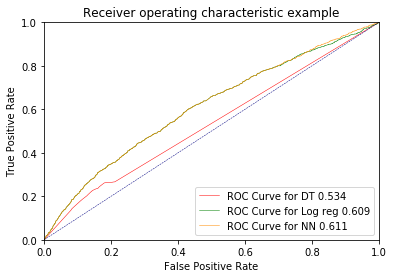

In [24]:
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt[:,1])
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test, y_pred_proba_log_reg[:,1])
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_proba_nn[:,1])

plt.plot(fpr_dt, tpr_dt, label='ROC Curve for DT {:.3f}'.format(roc_index_dt), color='red', lw=0.5)
plt.plot(fpr_log_reg, tpr_log_reg, label='ROC Curve for Log reg {:.3f}'.format(roc_index_log_reg), color='green', lw=0.5)
plt.plot(fpr_nn, tpr_nn, label='ROC Curve for NN {:.3f}'.format(roc_index_nn), color='darkorange', lw=0.5)

# plt.plot(fpr[2], tpr[2], color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Ensemble Model

In [25]:
# initialise the classifier with 3 different estimators
voting = VotingClassifier(estimators=[('dt', modelDT), ('lr', modelLG), ('nn', modelMLP)], voting='soft')

# fit the voting classifier to training data
voting.fit(X_train, y_train)

# evaluate train and test accuracy
print("Ensemble train accuracy:", voting.score(X_train, y_train))
print("Ensemble test accuracy:", voting.score(X_test, y_test))

# evaluate ROC auc score
y_pred_proba_ensemble = voting.predict_proba(X_test)
roc_index_ensemble = roc_auc_score(y_test, y_pred_proba_ensemble[:, 1])
print("ROC score of voting classifier:", roc_index_ensemble)

Ensemble train accuracy: 0.9523030303030303
Ensemble test accuracy: 0.856381044721852
ROC score of voting classifier: 0.655989847516911
